# Machine Learning System Design


## Introduction and Initial Setup

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext dotenv
%dotenv

import json
import logging
import sys
from pathlib import Path

import ipytest

import os
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

import boto3
import sagemaker
from sagemaker.workflow.pipeline_context import LocalPipelineSession, PipelineSession
from sagemaker.workflow.steps import CacheConfig
from sagemaker.workflow.parameters import ParameterString
from sagemaker.workflow.pipeline_definition_config import PipelineDefinitionConfig
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.workflow.steps import ProcessingStep
from sagemaker.workflow.pipeline import Pipeline
from sagemaker.pytorch import PyTorch
from sagemaker.inputs import TrainingInput
from sagemaker.workflow.steps import TrainingStep

CODE_FOLDER = Path("code")
CODE_FOLDER.mkdir(exist_ok=True)
sys.path.extend([f"./{CODE_FOLDER}"])

DATA_FILEPATH = "penguins.csv"

ipytest.autoconfig(raise_on_error=True)

# By default, The SageMaker SDK logs events related to the default
# configuration using the INFO level. To prevent these from spoiling
# the output of this notebook cells, we can change the logging
# level to ERROR instead.
logging.getLogger("sagemaker.config").setLevel(logging.ERROR)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [3]:
LOCAL_MODE = False

In [4]:
bucket = os.environ["BUCKET"]
role = os.environ["ROLE"]

COMET_API_KEY = os.environ.get("COMET_API_KEY", None)
COMET_PROJECT_NAME = os.environ.get("COMET_PROJECT_NAME", None)

In [6]:
# print(bucket)
# print(role)
# print(COMET_PROJECT_NAME)

In [7]:
# We can retrieve the architecture of the local
# computer using the `uname -m` command.
architecture = !(uname -m)

IS_ARM64_ARCHITECTURE = architecture[0] == "arm64"

In [8]:
pipeline_session = PipelineSession(default_bucket=bucket) if not LOCAL_MODE else None

if LOCAL_MODE:
    config = {
        "session": LocalPipelineSession(default_bucket=bucket),
        "instance_type": "local",
        # We need to use a custom Docker image when we run the pipeline
        # in Local Model on an ARM64 machine.
        "image": (
            "sagemaker-tensorflow-toolkit-local" if IS_ARM64_ARCHITECTURE else None
        ),
    }
else:
    config = {
        "session": pipeline_session,
        "instance_type": "ml.m5.xlarge",
        "image": None,
    }

# These specific settings refer to the SageMaker
# Pytorch container we'll use.
config["framework_version"] = "2.2.0"
config["py_version"] = "py310"

[01/19/25 17:28:36] INFO     Found credentials in shared credentials file: ~/.aws/credentials   ]8;id=413056;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=949848;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/botocore/credentials.py#1278\1278]8;;\

In [9]:
S3_LOCATION = f"s3://{bucket}/penguins"

sagemaker_session = sagemaker.session.Session()
sagemaker_client = boto3.client("sagemaker")
iam_client = boto3.client("iam")
region = boto3.Session().region_name

[01/19/25 17:28:37] INFO     Found credentials in shared credentials file: ~/.aws/credentials   ]8;id=737032;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=787575;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/botocore/credentials.py#1278\1278]8;;\

                    INFO     Found credentials in shared credentials file: ~/.aws/credentials   ]8;id=848926;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=389078;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/botocore/credentials.py#1278\1278]8;;\

## EDA

In [10]:
DATA_FILEPATH

'penguins.csv'

In [11]:
penguins = pd.read_csv(DATA_FILEPATH)
penguins.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


In [12]:
penguins.describe(include="all")

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
count,344,344,342.000000,342.000000,342.000000,342.000000,334
unique,3,3,NaN,NaN,NaN,NaN,3
top,Adelie,Biscoe,NaN,NaN,NaN,NaN,MALE
freq,152,168,NaN,NaN,NaN,NaN,168
mean,NaN,NaN,43.921930,17.151170,200.915205,4201.754386,NaN
std,NaN,NaN,5.459584,1.974793,14.061714,801.954536,NaN
min,NaN,NaN,32.100000,13.100000,172.000000,2700.000000,NaN
25%,NaN,NaN,39.225000,15.600000,190.000000,3550.000000,NaN
50%,NaN,NaN,44.450000,17.300000,197.000000,4050.000000,NaN
75%,NaN,NaN,48.500000,18.700000,213.000000,4750.000000,NaN


In [13]:
species_distribution = penguins["species"].value_counts()
island_distribution = penguins["island"].value_counts()
sex_distribution = penguins["sex"].value_counts()

print(species_distribution, end="\n\n")
print(island_distribution, end="\n\n")
print(sex_distribution)

species
Adelie       152
Gentoo       124
Chinstrap     68
Name: count, dtype: int64

island
Biscoe       168
Dream        124
Torgersen     52
Name: count, dtype: int64

sex
MALE      168
FEMALE    165
.           1
Name: count, dtype: int64


In [14]:
penguins["sex"] = penguins["sex"].replace(".", np.nan)

# Let's display the new distribution of the column:
sex_distribution = penguins["sex"].value_counts()
sex_distribution

sex
MALE      168
FEMALE    165
Name: count, dtype: int64

### Deling with Missing Values

In [15]:
imputer = SimpleImputer(strategy="most_frequent")
penguins.iloc[:, :] = imputer.fit_transform(penguins)

# Let's display again the number of missing values:
penguins.isna().sum()

species              0
island               0
culmen_length_mm     0
culmen_depth_mm      0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

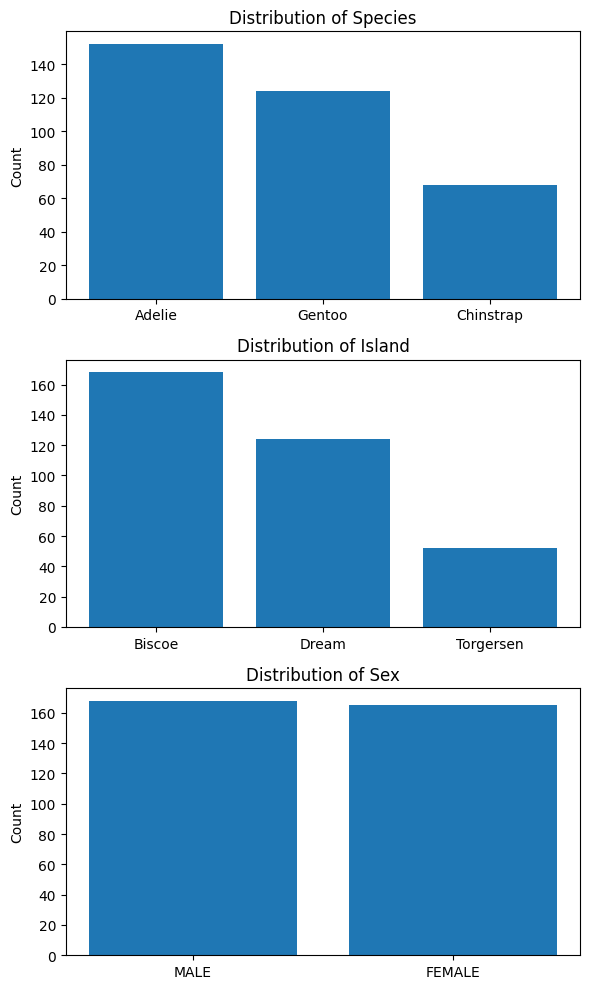

In [16]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(6, 10))

axs[0].bar(species_distribution.index, species_distribution.values)
axs[0].set_ylabel("Count")
axs[0].set_title("Distribution of Species")

axs[1].bar(island_distribution.index, island_distribution.values)
axs[1].set_ylabel("Count")
axs[1].set_title("Distribution of Island")

axs[2].bar(sex_distribution.index, sex_distribution.values)
axs[2].set_ylabel("Count")
axs[2].set_title("Distribution of Sex")

plt.tight_layout()
plt.show()

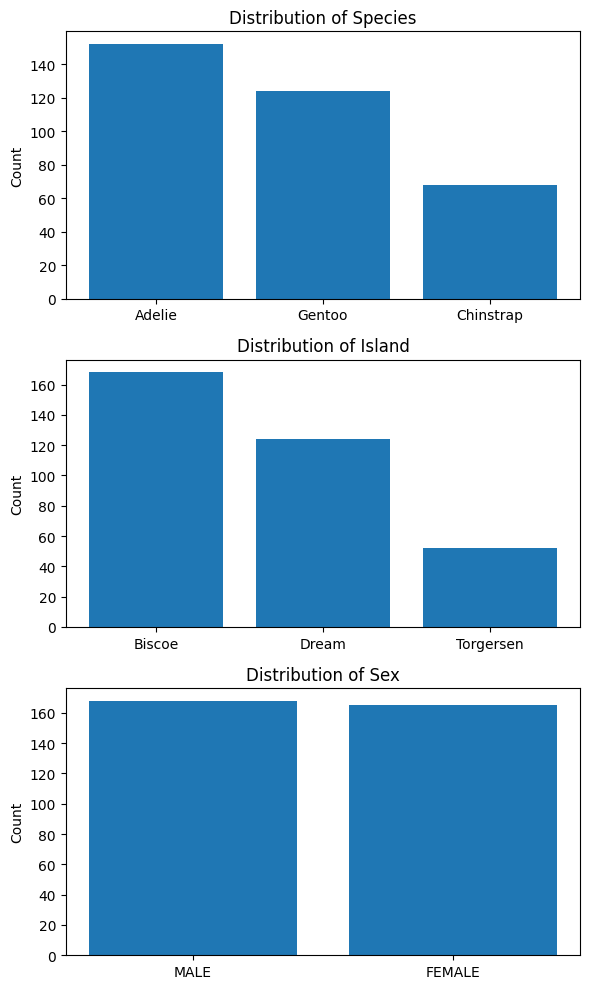

: 

: 

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(6, 10))

axs[0].bar(species_distribution.index, species_distribution.values)
axs[0].set_ylabel("Count")
axs[0].set_title("Distribution of Species")

axs[1].bar(island_distribution.index, island_distribution.values)
axs[1].set_ylabel("Count")
axs[1].set_title("Distribution of Island")

axs[2].bar(sex_distribution.index, sex_distribution.values)
axs[2].set_ylabel("Count")
axs[2].set_title("Distribution of Sex")

plt.tight_layout()
plt.show()

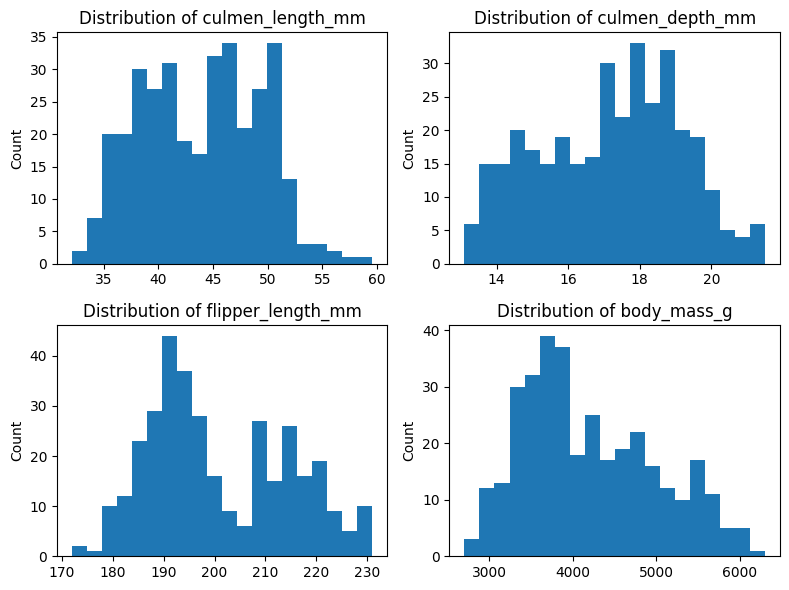

: 

: 

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6))

axs[0, 0].hist(penguins["culmen_length_mm"], bins=20)
axs[0, 0].set_ylabel("Count")
axs[0, 0].set_title("Distribution of culmen_length_mm")

axs[0, 1].hist(penguins["culmen_depth_mm"], bins=20)
axs[0, 1].set_ylabel("Count")
axs[0, 1].set_title("Distribution of culmen_depth_mm")

axs[1, 0].hist(penguins["flipper_length_mm"], bins=20)
axs[1, 0].set_ylabel("Count")
axs[1, 0].set_title("Distribution of flipper_length_mm")

axs[1, 1].hist(penguins["body_mass_g"], bins=20)
axs[1, 1].set_ylabel("Count")
axs[1, 1].set_title("Distribution of body_mass_g")

plt.tight_layout()
plt.show()

In [17]:
penguins.cov(numeric_only=True)

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
culmen_length_mm,29.679415,-2.516984,50.260588,2596.971151
culmen_depth_mm,-2.516984,3.877201,-16.108849,-742.660180
flipper_length_mm,50.260588,-16.108849,197.269501,9792.552037
body_mass_g,2596.971151,-742.660180,9792.552037,640316.716388


In [18]:
penguins.corr(numeric_only=True)

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
culmen_length_mm,1.000000,-0.234635,0.656856,0.595720
culmen_depth_mm,-0.234635,1.000000,-0.582472,-0.471339
flipper_length_mm,0.656856,-0.582472,1.000000,0.871302
body_mass_g,0.595720,-0.471339,0.871302,1.000000


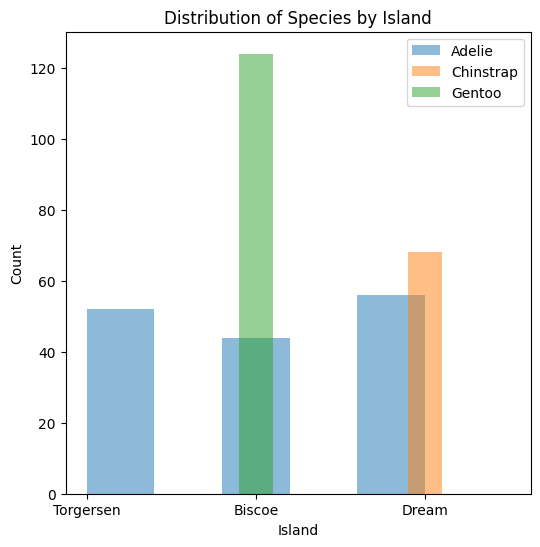

In [19]:
unique_species = penguins["species"].unique()

fig, ax = plt.subplots(figsize=(6, 6))
for species in unique_species:
    data = penguins[penguins["species"] == species]
    ax.hist(data["island"], bins=5, alpha=0.5, label=species)

ax.set_xlabel("Island")
ax.set_ylabel("Count")
ax.set_title("Distribution of Species by Island")
ax.legend()
plt.show()

## Transforming the Data

### Preprocessing Script

In [20]:
(CODE_FOLDER / "processing").mkdir(parents=True, exist_ok=True)

In [21]:
%%writefile {CODE_FOLDER}/processing/script.py
# | filename: script.py
# | code-line-numbers: true

import os
import tarfile
import tempfile
from pathlib import Path

import joblib
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler


def preprocess(base_directory):
    """Load the supplied data, split it and transform it."""
    df = _read_data_from_input_csv_files(base_directory)

    target_transformer = ColumnTransformer(
        transformers=[("species", OrdinalEncoder(), [0])],
    )

    numeric_transformer = make_pipeline(
        SimpleImputer(strategy="mean"),
        StandardScaler(),
    )

    categorical_transformer = make_pipeline(
        SimpleImputer(strategy="most_frequent"),
        OneHotEncoder(),
    )

    features_transformer = ColumnTransformer(
        transformers=[
            (
                "numeric",
                numeric_transformer,
                make_column_selector(dtype_exclude="object"),
            ),
            ("categorical", categorical_transformer, ["island"]),
        ],
    )

    df_train, df_validation, df_test = _split_data(df)

    _save_train_baseline(base_directory, df_train)
    _save_test_baseline(base_directory, df_test)

    y_train = target_transformer.fit_transform(
        np.array(df_train.species.values).reshape(-1, 1),
    )
    y_validation = target_transformer.transform(
        np.array(df_validation.species.values).reshape(-1, 1),
    )
    y_test = target_transformer.transform(
        np.array(df_test.species.values).reshape(-1, 1),
    )

    df_train = df_train.drop("species", axis=1)
    df_validation = df_validation.drop("species", axis=1)
    df_test = df_test.drop("species", axis=1)

    X_train = features_transformer.fit_transform(df_train)  # noqa: N806
    X_validation = features_transformer.transform(df_validation)  # noqa: N806
    X_test = features_transformer.transform(df_test)  # noqa: N806

    _save_splits(
        base_directory,
        X_train,
        y_train,
        X_validation,
        y_validation,
        X_test,
        y_test,
    )
    _save_model(base_directory, target_transformer, features_transformer)


def _read_data_from_input_csv_files(base_directory):
    """Read the data from the input CSV files.

    This function reads every CSV file available and
    concatenates them into a single dataframe.
    """
    input_directory = Path(base_directory) / "input"
    files = list(input_directory.glob("*.csv"))

    if len(files) == 0:
        message = f"The are no CSV files in {input_directory.as_posix()}/"
        raise ValueError(message)

    raw_data = [pd.read_csv(file) for file in files]
    df = pd.concat(raw_data)

    # Shuffle the data
    return df.sample(frac=1, random_state=42)


def _split_data(df):
    """Split the data into train, validation, and test."""
    df_train, temp = train_test_split(df, test_size=0.3)
    df_validation, df_test = train_test_split(temp, test_size=0.5)

    return df_train, df_validation, df_test


def _save_train_baseline(base_directory, df_train):
    """Save the untransformed training data to disk.

    We will need the training data to compute a baseline to
    determine the quality of the data that the model receives
    when deployed.
    """
    baseline_path = Path(base_directory) / "train-baseline"
    baseline_path.mkdir(parents=True, exist_ok=True)

    df = df_train.copy().dropna()

    # To compute the data quality baseline, we don't need the
    # target variable, so we'll drop it from the dataframe.
    df = df.drop("species", axis=1)

    df.to_csv(baseline_path / "train-baseline.csv", header=True, index=False)


def _save_test_baseline(base_directory, df_test):
    """Save the untransformed test data to disk.

    We will need the test data to compute a baseline to
    determine the quality of the model predictions when deployed.
    """
    baseline_path = Path(base_directory) / "test-baseline"
    baseline_path.mkdir(parents=True, exist_ok=True)

    df = df_test.copy().dropna()

    # We'll use the test baseline to generate predictions later,
    # and we can't have a header line because the model won't be
    # able to make a prediction for it.
    df.to_csv(baseline_path / "test-baseline.csv", header=False, index=False)


def _save_splits(
    base_directory,
    X_train,  # noqa: N803
    y_train,
    X_validation,  # noqa: N803
    y_validation,
    X_test,  # noqa: N803
    y_test,
):
    """Save data splits to disk.

    This function concatenates the transformed features
    and the target variable, and saves each one of the split
    sets to disk.
    """
    train = np.concatenate((X_train, y_train), axis=1)
    validation = np.concatenate((X_validation, y_validation), axis=1)
    test = np.concatenate((X_test, y_test), axis=1)

    train_path = Path(base_directory) / "train"
    validation_path = Path(base_directory) / "validation"
    test_path = Path(base_directory) / "test"

    train_path.mkdir(parents=True, exist_ok=True)
    validation_path.mkdir(parents=True, exist_ok=True)
    test_path.mkdir(parents=True, exist_ok=True)

    pd.DataFrame(train).to_csv(train_path / "train.csv", header=False, index=False)
    pd.DataFrame(validation).to_csv(
        validation_path / "validation.csv",
        header=False,
        index=False,
    )
    pd.DataFrame(test).to_csv(test_path / "test.csv", header=False, index=False)


def _save_model(base_directory, target_transformer, features_transformer):
    """Save the Scikit-Learn transformation pipelines.

    This function creates a model.tar.gz file that
    contains the two transformation pipelines we built
    to transform the data.
    """
    with tempfile.TemporaryDirectory() as directory:
        joblib.dump(target_transformer, Path(directory) / "target.joblib")
        joblib.dump(features_transformer, Path(directory) / "features.joblib")

        model_path = Path(base_directory) / "model"
        model_path.mkdir(parents=True, exist_ok=True)

        with tarfile.open(f"{(model_path / 'model.tar.gz').as_posix()}", "w:gz") as tar:
            tar.add(Path(directory) / "target.joblib", arcname="target.joblib")
            tar.add(
                Path(directory) / "features.joblib", arcname="features.joblib",
            )


if __name__ == "__main__":
    preprocess(base_directory="/opt/ml/processing")

Overwriting code/processing/script.py


In [22]:
%%ipytest -s
# | code-fold: true

import os
import shutil
import tarfile
import tempfile

import pytest
from processing.script import preprocess


@pytest.fixture(autouse=False)
def directory():
    directory = tempfile.mkdtemp()
    input_directory = Path(directory) / "input"
    input_directory.mkdir(parents=True, exist_ok=True)
    shutil.copy2(DATA_FILEPATH, input_directory / "data.csv")

    directory = Path(directory)
    preprocess(base_directory=directory)

    yield directory

    shutil.rmtree(directory)


def test_preprocess_generates_data_splits(directory):
    output_directories = os.listdir(directory)

    assert "train" in output_directories
    assert "validation" in output_directories
    assert "test" in output_directories


def test_preprocess_generates_baselines(directory):
    output_directories = os.listdir(directory)

    assert "train-baseline" in output_directories
    assert "test-baseline" in output_directories


def test_preprocess_creates_two_models(directory):
    model_path = directory / "model"
    tar = tarfile.open(model_path / "model.tar.gz", "r:gz")

    assert "features.joblib" in tar.getnames()
    assert "target.joblib" in tar.getnames()


def test_splits_are_transformed(directory):
    train = pd.read_csv(directory / "train" / "train.csv", header=None)
    validation = pd.read_csv(directory / "validation" / "validation.csv", header=None)
    test = pd.read_csv(directory / "test" / "test.csv", header=None)

    # After transforming the data, the number of features should be 7:
    # * 3 - island (one-hot encoded)
    # * 1 - culmen_length_mm = 1
    # * 1 - culmen_depth_mm
    # * 1 - flipper_length_mm
    # * 1 - body_mass_g
    number_of_features = 7

    # The transformed splits should have an additional column for the target
    # variable.
    assert train.shape[1] == number_of_features + 1
    assert validation.shape[1] == number_of_features + 1
    assert test.shape[1] == number_of_features + 1


def test_train_baseline_is_not_transformed(directory):
    baseline = pd.read_csv(
        directory / "train-baseline" / "train-baseline.csv",
        header=None,
    )

    island = baseline.iloc[:, 0].unique()

    assert "Biscoe" in island
    assert "Torgersen" in island
    assert "Dream" in island


def test_test_baseline_is_not_transformed(directory):
    baseline = pd.read_csv(
        directory / "test-baseline" / "test-baseline.csv", header=None
    )

    island = baseline.iloc[:, 1].unique()

    assert "Biscoe" in island
    assert "Torgersen" in island
    assert "Dream" in island


def test_train_baseline_includes_header(directory):
    baseline = pd.read_csv(directory / "train-baseline" / "train-baseline.csv")
    assert baseline.columns[0] == "island"


def test_test_baseline_does_not_include_header(directory):
    baseline = pd.read_csv(directory / "test-baseline" / "test-baseline.csv")
    assert baseline.columns[0] != "island"

........
8 passed in 0.57s


### Caching Configuration

In [23]:
cache_config = CacheConfig(enable_caching=True, expire_after="15d")

### Pipeline Configuration

In [24]:
pipeline_definition_config = PipelineDefinitionConfig(use_custom_job_prefix=True)

dataset_location = ParameterString(
    name="dataset_location",
    default_value=f"{S3_LOCATION}/data",
)

### Setting up the Processing Step

In [25]:
processor = SKLearnProcessor(
    base_job_name="preprocess-data",
    framework_version="1.2-1",
    # By default, a new account doesn't have access to `ml.m5.xlarge` instances.
    # If you haven't requested a quota increase yet, you can use an
    # `ml.t3.medium` instance type instead. This will work out of the box, but
    # the Processing Job will take significantly longer than it should have.
    # To get access to `ml.m5.xlarge` instances, you can request a quota
    # increase under the Service Quotas section in your AWS account.
    instance_type=config["instance_type"],
    instance_count=1,
    role=role,
    sagemaker_session=config["session"],
)

[01/19/25 17:29:04] INFO     Defaulting to only available Python version: py3                     ]8;id=880860;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=225951;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/image_uris.py#608\608]8;;\

In [26]:
preprocessing_step = ProcessingStep(
    name="preprocess-data",
    step_args=processor.run(
        code=f"{(CODE_FOLDER / 'processing' / 'script.py').as_posix()}",
        inputs=[
            ProcessingInput(
                source=dataset_location,
                destination="/opt/ml/processing/input",
            ),
        ],
        outputs=[
            ProcessingOutput(
                output_name="train",
                source="/opt/ml/processing/train",
                destination=f"{S3_LOCATION}/preprocessing/train",
            ),
            ProcessingOutput(
                output_name="validation",
                source="/opt/ml/processing/validation",
                destination=f"{S3_LOCATION}/preprocessing/validation",
            ),
            ProcessingOutput(
                output_name="test",
                source="/opt/ml/processing/test",
                destination=f"{S3_LOCATION}/preprocessing/test",
            ),
            ProcessingOutput(
                output_name="model",
                source="/opt/ml/processing/model",
                destination=f"{S3_LOCATION}/preprocessing/model",
            ),
            ProcessingOutput(
                output_name="train-baseline",
                source="/opt/ml/processing/train-baseline",
                destination=f"{S3_LOCATION}/preprocessing/train-baseline",
            ),
            ProcessingOutput(
                output_name="test-baseline",
                source="/opt/ml/processing/test-baseline",
                destination=f"{S3_LOCATION}/preprocessing/test-baseline",
            ),
        ],
    ),
    cache_config=cache_config,
)

/Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/workflow/pipeline_context.py:332: UserWarning: Running within a PipelineSession, there will be No Wait, No Logs, and No Job being started.
  warnings.warn(


### Creating the Pipeline

In [27]:
preprocessing_pipeline = Pipeline(
    name="preprocessing-pipeline",
    parameters=[dataset_location],
    steps=[
        preprocessing_step,
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=config["session"],
)

preprocessing_pipeline.upsert(role_arn=role)

{'PipelineArn': 'arn:aws:sagemaker:us-west-2:418272792030:pipeline/preprocessing-pipeline',
 'ResponseMetadata': {'RequestId': '82eda437-a98d-4642-b965-b4cb8a614f5a',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '82eda437-a98d-4642-b965-b4cb8a614f5a',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '90',
   'date': 'Mon, 20 Jan 2025 01:29:07 GMT'},
  'RetryAttempts': 0}}

In [28]:
#preprocessing_pipeline.start()

: 

: 

## Training the Model

### Creating the Training Script

In [28]:
(CODE_FOLDER / "training").mkdir(parents=True, exist_ok=True)

In [29]:
%%writefile {CODE_FOLDER}/training/script.py
# | filename: script.py
# | code-line-numbers: true

import argparse
import json
import os
import tarfile
from pathlib import Path
from comet_ml import Experiment

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np


class SimpleModel(nn.Module):
    def __init__(self, input_size):
        super(SimpleModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 10),
            nn.ReLU(),
            nn.Linear(10, 8),
            nn.ReLU(),
            nn.Linear(8, 3),
            nn.Softmax(dim=1),
        )

    def forward(self, x):
        return self.layers(x)


def train(
    model_directory,
    train_path,
    validation_path,
    pipeline_path,
    experiment,
    epochs=50,
    batch_size=32,
    learning_rate=0.01,
):
    print(f"Using PyTorch version: {torch.__version__}")

    # Load datasets
    X_train = pd.read_csv(Path(train_path) / "train.csv")
    y_train = X_train.pop(X_train.columns[-1]).values
    X_train = X_train.values

    X_validation = pd.read_csv(Path(validation_path) / "validation.csv")
    y_validation = X_validation.pop(X_validation.columns[-1]).values
    X_validation = X_validation.values

    # Convert to tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_validation_tensor = torch.tensor(X_validation, dtype=torch.float32)
    y_validation_tensor = torch.tensor(y_validation, dtype=torch.long)

    # DataLoaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    validation_dataset = TensorDataset(X_validation_tensor, y_validation_tensor)
    validation_loader = DataLoader(validation_dataset, batch_size=batch_size)

    # Initialize the model, loss function, and optimizer
    model = SimpleModel(input_size=X_train.shape[1])
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss:.4f}")

    # Validation
    model.eval()
    all_preds = []
    with torch.no_grad():
        for batch_X, _ in validation_loader:
            outputs = model(batch_X)
            predictions = outputs.argmax(dim=1)
            all_preds.extend(predictions.cpu().numpy())
    val_accuracy = accuracy_score(y_validation, all_preds)
    print(f"Validation accuracy: {val_accuracy:.4f}")

    # Save the model
    model_filepath = Path(model_directory) / "penguins.pth"
    torch.save(model.state_dict(), model_filepath)

    # Save transformation pipelines
    with tarfile.open(Path(pipeline_path) / "model.tar.gz", "r:gz") as tar:
        tar.extractall(model_directory)

    # Log metrics and artifacts
    if experiment:
        experiment.log_parameters(
            {
                "epochs": epochs,
                "batch_size": batch_size,
                "learning_rate": learning_rate,
            }
        )
        experiment.log_dataset_hash(X_train)
        experiment.log_confusion_matrix(y_validation, np.array(all_preds))
        experiment.log_model("penguins", model_filepath.as_posix())


if __name__ == "__main__":
    # Parse hyperparameters
    parser = argparse.ArgumentParser()
    parser.add_argument("--epochs", type=int, default=50)
    parser.add_argument("--batch_size", type=int, default=32)
    args, _ = parser.parse_known_args()

    # Comet experiment
    comet_api_key = os.environ.get("COMET_API_KEY", None)
    comet_project_name = os.environ.get("COMET_PROJECT_NAME", None)

    experiment = (
        Experiment(
            project_name=comet_project_name,
            api_key=comet_api_key,
            auto_metric_logging=True,
            auto_param_logging=True,
            log_code=True,
        )
        if comet_api_key and comet_project_name
        else None
    )

    training_env = json.loads(os.environ.get("SM_TRAINING_ENV", {}))
    job_name = training_env.get("job_name", None) if training_env else None

    if job_name and experiment:
        experiment.set_name(job_name)

    # Train the model
    train(
        model_directory=os.environ["SM_MODEL_DIR"],
        train_path=os.environ["SM_CHANNEL_TRAIN"],
        validation_path=os.environ["SM_CHANNEL_VALIDATION"],
        pipeline_path=os.environ["SM_CHANNEL_PIPELINE"],
        experiment=experiment,
        epochs=args.epochs,
        batch_size=args.batch_size,
    )

Overwriting code/training/script.py


In [31]:
%%ipytest -s
#| code-fold: true

import os
import shutil
import pytest
import tempfile

from processing.script import preprocess
from training.script import train

@pytest.fixture(scope="function", autouse=False)
def directory():
    directory = tempfile.mkdtemp()
    input_directory = Path(directory) / "input"
    input_directory.mkdir(parents=True, exist_ok=True)
    shutil.copy2(DATA_FILEPATH, input_directory / "data.csv")
    
    directory = Path(directory)
    
    preprocess(base_directory=directory)
    train(
        model_directory=directory / "model",
        train_path=directory / "train", 
        validation_path=directory / "validation",
        pipeline_path=directory / "model",
        experiment=None,
        epochs=1
    )
    
    yield directory
    
    shutil.rmtree(directory)


def test_train_bundles_model_assets(directory):
    # Check the model directory contents
    bundle = os.listdir(directory / "model")
    assert "penguins.pth" in bundle, "Model file 'penguins.pth' not found in the model directory."


def test_train_bundles_transformation_pipelines(directory):
    # Check the pipeline directory contents
    bundle = os.listdir(directory / "model")
    assert "model.tar.gz" in bundle, "Transformation pipeline 'model.tar.gz' not found in the model directory."

    # Ensure the tar.gz file can be extracted
    with tempfile.TemporaryDirectory() as temp_extract_dir:
        tar_path = directory / "model" / "model.tar.gz"
        shutil.unpack_archive(tar_path, temp_extract_dir)
        extracted_files = os.listdir(temp_extract_dir)
        assert len(extracted_files) > 0, "Extracted transformation pipelines are empty."

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:9                                                                                    │
│                                                                                                  │
│    6 import tempfile                                                                             │
│    7                                                                                             │
│    8 from processing.script import preprocess                                                    │
│ ❱  9 from training.script import train                                                           │
│   10                                                                                             │
│   11 @pytest.fixture(scope="function", autouse=False)                                            │
│   12 def directory():                                                                            │
│                                                                                                  │
│ /Users/anchit/Desktop/MLSchool/ml.school_repo/mycode/./code/training/script.py:11 in <module>    │
│                                                                                                  │
│     8 from pathlib import Path                                                                   │
│     9 from comet_ml import Experiment                                                            │
│    10                                                                                            │
│ ❱  11 import torch                                                                               │
│    12 import torch.nn as nn                                                                      │
│    13 import torch.optim as optim                                                                │
│    14 from torch.utils.data import DataLoader, TensorDataset                                     │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
ModuleNotFoundError: No module named 'torch'


no tests ran in 0.01s


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 get_ipython().run_cell_magic('ipytest', '-s', '#| code-fold: true\n\nimport os\nimport s     │
│   2                                                                                              │
│                                                                                                  │
│ /Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/IPython/core/in │
│ teractiveshell.py:2541 in run_cell_magic                                                         │
│                                                                                                  │
│   2538 │   │   │                                                                                 │
│   2539 │   │   │   with self.builtin_trap:                                                       │
│   2540 │   │   │   │   args = (magic_arg_s, cell)                                                │
│ ❱ 2541 │   │   │   │   result = fn(*args, **kwargs)                                              │
│   2542 │   │   │                                                                                 │
│   2543 │   │   │   # The code below prevents the output from being displayed                     │
│   2544 │   │   │   # when using magics with decorator @output_can_be_silenced                    │
│                                                                                                  │
│ /Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/ipytest/_impl.p │
│ y:166 in ipytest_magic                                                                           │
│                                                                                                  │
│   163 │   │                                                                                      │
│   164 │   │   raise e                                                                            │
│   165 │                                                                                          │
│ ❱ 166 │   run(*run_args, **run_kwargs)                                                           │
│   167                                                                                            │
│   168                                                                                            │
│   169 # NOTE equivalent to @no_var_expand but does not require an IPython import                 │
│                                                                                                  │
│ /Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/ipytest/_impl.p │
│ y:89 in run                                                                                      │
│                                                                                                  │
│    86 │   ipytest.exit_code = exit_code                                                          │
│    87 │                                                                                          │
│    88 │   if raise_on_error is True and exit_code != 0:                                          │
│ ❱  89 │   │   raise Error(exit_code)                                                             │
│    90 │                                                                                          │
│    91 │   return exit_code                                                                       │
│    92                                                                                            │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
Error: ipytest failed with exit_code 5

### Setting up the Training Step


In [ ]:
%%writefile {CODE_FOLDER}/training/requirements.txt
#| label: requirements.txt
#| filename: requirements.txt
#| code-line-numbers: false

comet_ml
torch==2.2.0

Overwriting code/training/requirements.txt


: 

In [33]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    base_job_name="training",
    entry_point="script.py",
    source_dir=f"{(CODE_FOLDER / 'training').as_posix()}",
    # SageMaker will pass these hyperparameters as arguments
    # to the entry point of the training script.
    hyperparameters={
        "epochs": 50,
        "batch_size": 32,
    },
    # SageMaker will create these environment variables on the
    # Training Job instance.
    environment={
        "COMET_API_KEY": COMET_API_KEY,
        "COMET_PROJECT_NAME": COMET_PROJECT_NAME,
    },
    # SageMaker will track these metrics as part of the experiment
    # associated to this pipeline. The metric definitions tells
    # SageMaker how to parse the values from the Training Job logs.
    metric_definitions=[
        {"Name": "loss", "Regex": "loss: ([0-9\\.]+)"},
        {"Name": "accuracy", "Regex": "accuracy: ([0-9\\.]+)"},
        {"Name": "val_loss", "Regex": "val_loss: ([0-9\\.]+)"},
        {"Name": "val_accuracy", "Regex": "val_accuracy: ([0-9\\.]+)"},
    ],
    # Specify the PyTorch Docker image URI or use a pre-built one
    image_uri=config["image"],
    framework_version=config["framework_version"],  # Example: "1.13.1"
    py_version=config["py_version"],               # Example: "py39"
    instance_type=config["instance_type"],         # Example: "ml.p3.2xlarge"
    instance_count=1,
    disable_profiler=True,
    debugger_hook_config=False,
    sagemaker_session=config["session"],
    role=role,
)


: 

In [34]:
def create_training_step(estimator):
    """Create a SageMaker TrainingStep using the provided estimator."""
    return TrainingStep(
        name="train-model",
        step_args=estimator.fit(
            inputs={
                "train": TrainingInput(
                    s3_data=preprocessing_step.properties.ProcessingOutputConfig.Outputs[
                        "train"
                    ].S3Output.S3Uri,
                    content_type="text/csv",
                ),
                "validation": TrainingInput(
                    s3_data=preprocessing_step.properties.ProcessingOutputConfig.Outputs[
                        "validation"
                    ].S3Output.S3Uri,
                    content_type="text/csv",
                ),
                "pipeline": TrainingInput(
                    s3_data=preprocessing_step.properties.ProcessingOutputConfig.Outputs[
                        "model"
                    ].S3Output.S3Uri,
                    content_type="application/tar+gzip",
                ),
            },
        ),
        cache_config=cache_config,
    )


train_model_step = create_training_step(estimator)

[01/19/25 16:58:27] INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=855341;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=257522;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py#90\90]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

/Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/workflow/pipeline_context.py:332: UserWarning: Running within a PipelineSession, there will be No Wait, No Logs, and No Job being started.
  warnings.warn(


: 

### Creating the Pipeline

In [35]:
training_pytorch_pipeline = Pipeline(
    name="training-pytorch-pipeline",
    parameters=[dataset_location],
    steps=[
        preprocessing_step,
        train_model_step,
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=config["session"],
)

training_pytorch_pipeline.upsert(role_arn=role)

[autoreload of botocore.exceptions failed: Traceback (most recent call last):
  File "/Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
  File "/usr/local/Cellar/python@3.10/3.10.9/Frameworks/Python.framework/Versions/3.10/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/botocore/exceptions.py", line 129, in <module>
    class SSLError(Connectio

AttributeError: module 'botocore' has no attribute 'client'